---
title: "MRI - Spin relaxation simulation"
author: "MLun Wong"
date: "2024-01-22"
categories: [DICOM, imaging, MRI, python, simulation]
format:
  html:
    toc: true
draft: true
jupyter: conda-env-data_analysis-py
---

::: {.callout-caution}

This page is under construction

:::

# About MRI

MRI offers wonderful soft-tissue resolution and various tissue contrast depending on the sequence involved. It is necessary to understand a bit of its principle before we talk about intensity normalization.

## Weighted-sequence

T1-weighted (T1w) and T2-weighted (T2w) are the most commonly acquired sequence using MRI. The voxel intensity of T1- and T2w images typically represents the time required by the spin to resume to the main-field alignment and to archive transverse plan relaxation, respectively.

### Quick intro - Bloch equations for nuclear magnetization

$$
\begin{aligned}
\frac{d\textbf{M}_x(t)}{dt}&=\gamma[\textbf{M}(t) \times \textbf{B}(t)]\cdot\hat{x}-\frac{M_x(t)}{T_2} \\
\frac{d\textbf{M}_y(t)}{dt}&=\gamma[\textbf{M}(t) \times \textbf{B}(t)]\cdot\hat{y}-\frac{M_y(t)}{T_2} \\
\frac{d\textbf{M}_z(t)}{dt}&=\gamma[\textbf{M}(t) \times \textbf{B}(t)]\cdot\hat{z}-\frac{M_z(t) - M_0}{T_1}
\end{aligned}
$$

Let the field experienced be only the main field $\textbf{B}(t)=B_0\hat{z}$ such that the cross product term becomes $-M_x(t)B_0\hat{y} + M_y(t)B_0\hat{x}$ and the equation becomes:

$$
\begin{aligned}
\frac{d\textbf{M}_x(t)}{dt}&=\gamma M_y(t)B_0 -\frac{M_x(t)}{T_2} \\
\frac{d\textbf{M}_y(t)}{dt}&=-\gamma M_x(t)B_0 -\frac{M_y(t)}{T_2} \\
\frac{d\textbf{M}_z(t)}{dt}&=-\frac{M_z(t) - M_0}{T_1}
\end{aligned}
$$

Solving this numerically is inefficient but simple. As a quick example, consider an initial magnitization of $\textbf{M}(0) = (1, 1, 1)$, with $\gamma = 1, T_1 = 4, T_2 = 8$, subjected to a constant main B-field of $\textbf{B}(t) = \hat{z}$: 


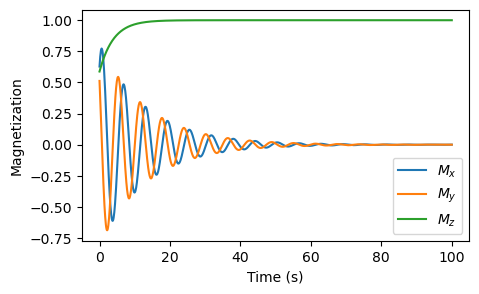

In [2]:
#| fig-cap: Basic simulation of relaxation

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from IPython.display import *

steps = 1000 # number of steps
T = 100. # simulation length
t = np.linspace(0, T, steps) # time axis
dt =t[1] - t[0] # time resolution
B = np.array([0, 0, 1.]) # Main B-field
M_0 = np.array([0., 0., 1.]) # equilibrium spin
gamma = 1 
T1 = 4 # These are the weighting that dictates how the spin relax to z-axis
T2 = 8 # These are the weighting that dictates how the spin relax to z-axis and transversely in xy plane

# Starting simulation
path = []
M = np.array([1., 1., 1.])
M /= norm(M)
for i in range(steps):
  bx, by, bz = B # ignore bx and by
  mx, my, mz = M
  dMx = gamma * my * bz - mx / T2
  dMy = -gamma * mx * bz - my / T2
  dMz = - (mz - norm(M_0)) / T1

  M = M + np.array([dMx, dMy, dMz]) * dt
  path.append(np.copy(M))
path = np.stack(path)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t, path[:, 0], label="$M_x$")
ax.plot(t, path[:, 1], label="$M_y$")
ax.plot(t, path[:, 2], label="$M_z$")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Magnetization")
plt.legend()
plt.show()

### Visualization in 3D

And this is how it looks in 3D

In [4]:
#| layout-align: center
#| vertical-align: center

import matplotlib.animation as animation

# make quiver from path
quiver = np.zeros_like(path)
quiver = np.concatenate([quiver, path], axis=1)

fig = plt.figure(figsize=(5, 5), dpi=75)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 1.5)
ax.xaxis.set_ticklabels([]) # turn off axis labels 
ax.yaxis.set_ticklabels([]) # turn off axis labels
ax.zaxis.set_ticklabels([]) # turn off axis labels 
quv = ax.quiver(*quiver[0]) # initialize vector display
line_path, = ax.plot(*path[0])

spf = 10 # steps per frae
frames = steps // spf - 1
interval = 50
def animate(i):
  global quv
  global line_path
  quv.remove()
  line_path.remove()
  quv = ax.quiver(*quiver[i * spf])
  line_path, = ax.plot(path[:i * spf, 0], path[:i * spf, 1], path[:i * spf, 2], 'green', alpha=0.5)
  return ax, 

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=frames, interval=interval)
plt.close()
display(HTML(ani.to_jshtml()))

Now while you see one arrow in the animation, there are many protons within the scan FOV and its impossible to considered each of them individually. Therefore, the term 

(to be continue)